In [1]:
import tensorflow as tf
import time
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
print(tf.__version__)
print(matplotlib.__version__)
print(np.__version__)

2.1.0
3.0.3
1.18.2


In [2]:
#hyperparameters
latent_dim = 100
lr = 1e-3
epochs = 1000
batch_size = 256
dropout_rate = 0.2
seed = 500
save_interval = 50 

In [3]:
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
class Generator(tf.keras.Model):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.Dense_1 = tf.keras.layers.Dense(128)
        self.Dense_2 = tf.keras.layers.Dense(28*28, activation='sigmoid')
        
        self.reshape = tf.keras.layers.Reshape((28,28,1))
    
    def call(self, inputs):
        x = self.Dense_1(inputs)
        x = tf.keras.layers.LeakyReLU()(x)
        x = self.Dense_2(x)
        x = self.reshape(x)
        return x

In [5]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        
        self.Dense_1 = tf.keras.layers.Dense(128)

        self.Dense_2 = tf.keras.layers.Dense(1, activation='sigmoid')
    
        self.dropout_1 = tf.keras.layers.Dropout(dropout_rate)

    
    def call(self, inputs):
        x = self.flatten(inputs)
        x = self.Dense_1(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = self.dropout_1(x)
        x = self.Dense_2(x)
        return x

In [6]:
gen = Generator()
disc = Discriminator()

(60000, 28, 28, 1)


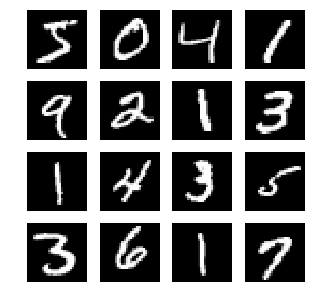

In [7]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data() # load the dataset
x_train = tf.cast(x_train, tf.float32)/255. #normalize the dataset
x_train = x_train[..., tf.newaxis] # add the channel axis
print(x_train.shape) 
#visualize some of the dataset
fig = plt.figure(figsize=(5, 5))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(x_train[i, :, :, 0] * 255.0, cmap='gray')
    plt.axis('off')

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(batch_size)

In [9]:
gen_opt = tf.keras.optimizers.Adam(lr)
disc_opt = tf.keras.optimizers.Adam(lr)

In [10]:
@tf.function
def train_step(images, batch_size):
    #train the discriminator
    noise = tf.random.normal([batch_size, latent_dim])
    
    with tf.GradientTape() as tape:
        gen_images = gen(noise)
        
        real_prob = disc(images)
        generated_prob = tf.debugging.check_numerics(disc(gen_images), 'disc prob of generated images')        

        disc_loss = -tf.reduce_mean(tf.math.log(real_prob) + tf.math.log(1. - generated_prob))
         
    tf.debugging.check_numerics(tf.math.log(real_prob), 'disc loss real prob part')
    tf.debugging.check_numerics(tf.math.log(1. - generated_prob), 
                                'disc loss gen prob part {}'.format(tf.math.reduce_max(generated_prob)))
        
    grad_disc = tape.gradient(disc_loss, disc.trainable_variables)
    disc_opt.apply_gradients(zip(grad_disc, disc.trainable_variables))
    
    #train the generator
    noise = tf.random.normal([batch_size, latent_dim])
    
    with tf.GradientTape() as tape:
        gen_images = gen(noise)
        
        generated_prob = disc(gen_images)
                
        gen_loss = -tf.reduce_mean(tf.math.log(generated_prob))
        
    tf.debugging.check_numerics(tf.math.log(generated_prob), 'gen loss part')
    
    grad_gen = tape.gradient(gen_loss, gen.trainable_variables)
    gen_opt.apply_gradients(zip(grad_gen, gen.trainable_variables))
    
    disc_real_acc = tf.reduce_mean(1 - (tf.ones_like(real_prob) - tf.cast(real_prob>=0.5, tf.float32)))
    disc_gen_acc = tf.reduce_mean(1 - (tf.ones_like(generated_prob) - tf.cast(generated_prob>=0.5, tf.float32)))
    
    return gen_loss, disc_loss, disc_real_acc, disc_gen_acc


In [11]:
def save_imgs(epoch, generator, noise):    
    gen_imgs = generator(noise)
    gen_imgs = gen_imgs.numpy()
    fig = plt.figure(figsize=(5, 5))
    for i in range(gen_imgs.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(gen_imgs[i, :, :, 0] * 255.0, cmap='gray')
        plt.axis('off')
    fig.savefig("images/mnist_%d.png" % epoch)

In [12]:
vis_noise = tf.random.normal([16, latent_dim])

Time for epoch 1 is 2.328 sec - gen_loss = 5.384, disc_loss = 0.199, disc_real_acc = 0.95, disc_gen_acc = 0.0
Time for epoch 2 is 1.16 sec - gen_loss = 10.427, disc_loss = 0.066, disc_real_acc = 0.99, disc_gen_acc = 0.0
Time for epoch 3 is 1.188 sec - gen_loss = 8.024, disc_loss = 0.03, disc_real_acc = 1.0, disc_gen_acc = 0.0
Time for epoch 4 is 1.092 sec - gen_loss = 6.413, disc_loss = 0.04, disc_real_acc = 1.0, disc_gen_acc = 0.0
Time for epoch 5 is 1.082 sec - gen_loss = 6.801, disc_loss = 0.044, disc_real_acc = 0.99, disc_gen_acc = 0.0
Time for epoch 6 is 1.081 sec - gen_loss = 5.972, disc_loss = 0.082, disc_real_acc = 0.99, disc_gen_acc = 0.01
Time for epoch 7 is 1.056 sec - gen_loss = 6.148, disc_loss = 0.114, disc_real_acc = 0.98, disc_gen_acc = 0.01
Time for epoch 8 is 1.064 sec - gen_loss = 5.243, disc_loss = 0.146, disc_real_acc = 0.97, disc_gen_acc = 0.01
Time for epoch 9 is 1.08 sec - gen_loss = 5.392, disc_loss = 0.183, disc_real_acc = 0.97, disc_gen_acc = 0.01
Time for ep

Time for epoch 75 is 1.081 sec - gen_loss = 2.283, disc_loss = 0.778, disc_real_acc = 0.81, disc_gen_acc = 0.12
Time for epoch 76 is 1.066 sec - gen_loss = 2.517, disc_loss = 0.848, disc_real_acc = 0.8, disc_gen_acc = 0.13
Time for epoch 77 is 1.071 sec - gen_loss = 3.124, disc_loss = 0.784, disc_real_acc = 0.82, disc_gen_acc = 0.12
Time for epoch 78 is 1.097 sec - gen_loss = 3.102, disc_loss = 0.68, disc_real_acc = 0.84, disc_gen_acc = 0.1
Time for epoch 79 is 1.078 sec - gen_loss = 2.588, disc_loss = 0.691, disc_real_acc = 0.84, disc_gen_acc = 0.12
Time for epoch 80 is 1.064 sec - gen_loss = 2.242, disc_loss = 0.704, disc_real_acc = 0.83, disc_gen_acc = 0.12
Time for epoch 81 is 1.066 sec - gen_loss = 2.119, disc_loss = 0.756, disc_real_acc = 0.81, disc_gen_acc = 0.12
Time for epoch 82 is 1.088 sec - gen_loss = 2.163, disc_loss = 0.793, disc_real_acc = 0.8, disc_gen_acc = 0.13
Time for epoch 83 is 1.076 sec - gen_loss = 2.441, disc_loss = 0.821, disc_real_acc = 0.81, disc_gen_acc = 0

Time for epoch 149 is 1.337 sec - gen_loss = 2.188, disc_loss = 0.844, disc_real_acc = 0.79, disc_gen_acc = 0.14
Time for epoch 150 is 1.323 sec - gen_loss = 2.301, disc_loss = 0.811, disc_real_acc = 0.8, disc_gen_acc = 0.14
Time for epoch 151 is 1.322 sec - gen_loss = 2.176, disc_loss = 0.825, disc_real_acc = 0.8, disc_gen_acc = 0.14
Time for epoch 152 is 1.107 sec - gen_loss = 2.039, disc_loss = 0.806, disc_real_acc = 0.8, disc_gen_acc = 0.14
Time for epoch 153 is 1.12 sec - gen_loss = 1.934, disc_loss = 0.847, disc_real_acc = 0.79, disc_gen_acc = 0.15
Time for epoch 154 is 1.095 sec - gen_loss = 1.891, disc_loss = 0.854, disc_real_acc = 0.78, disc_gen_acc = 0.15
Time for epoch 155 is 1.107 sec - gen_loss = 1.94, disc_loss = 0.844, disc_real_acc = 0.79, disc_gen_acc = 0.15
Time for epoch 156 is 1.088 sec - gen_loss = 1.979, disc_loss = 0.873, disc_real_acc = 0.78, disc_gen_acc = 0.15
Time for epoch 157 is 1.081 sec - gen_loss = 1.96, disc_loss = 0.854, disc_real_acc = 0.79, disc_gen_

Time for epoch 222 is 1.409 sec - gen_loss = 1.852, disc_loss = 0.858, disc_real_acc = 0.78, disc_gen_acc = 0.16
Time for epoch 223 is 1.463 sec - gen_loss = 1.864, disc_loss = 0.842, disc_real_acc = 0.79, disc_gen_acc = 0.15
Time for epoch 224 is 1.328 sec - gen_loss = 1.899, disc_loss = 0.859, disc_real_acc = 0.78, disc_gen_acc = 0.15
Time for epoch 225 is 1.383 sec - gen_loss = 1.882, disc_loss = 0.863, disc_real_acc = 0.78, disc_gen_acc = 0.15
Time for epoch 226 is 1.329 sec - gen_loss = 1.901, disc_loss = 0.856, disc_real_acc = 0.78, disc_gen_acc = 0.15
Time for epoch 227 is 1.374 sec - gen_loss = 1.904, disc_loss = 0.837, disc_real_acc = 0.79, disc_gen_acc = 0.15
Time for epoch 228 is 1.365 sec - gen_loss = 1.931, disc_loss = 0.858, disc_real_acc = 0.78, disc_gen_acc = 0.15
Time for epoch 229 is 1.369 sec - gen_loss = 1.912, disc_loss = 0.847, disc_real_acc = 0.79, disc_gen_acc = 0.15
Time for epoch 230 is 1.301 sec - gen_loss = 1.918, disc_loss = 0.854, disc_real_acc = 0.79, dis

Time for epoch 295 is 1.071 sec - gen_loss = 1.977, disc_loss = 0.805, disc_real_acc = 0.8, disc_gen_acc = 0.15
Time for epoch 296 is 1.092 sec - gen_loss = 1.931, disc_loss = 0.824, disc_real_acc = 0.79, disc_gen_acc = 0.15
Time for epoch 297 is 1.091 sec - gen_loss = 1.901, disc_loss = 0.831, disc_real_acc = 0.79, disc_gen_acc = 0.15
Time for epoch 298 is 1.147 sec - gen_loss = 1.912, disc_loss = 0.805, disc_real_acc = 0.8, disc_gen_acc = 0.15
Time for epoch 299 is 1.316 sec - gen_loss = 1.912, disc_loss = 0.814, disc_real_acc = 0.79, disc_gen_acc = 0.15
Time for epoch 300 is 1.328 sec - gen_loss = 1.916, disc_loss = 0.821, disc_real_acc = 0.79, disc_gen_acc = 0.15
Time for epoch 301 is 1.287 sec - gen_loss = 1.952, disc_loss = 0.8, disc_real_acc = 0.8, disc_gen_acc = 0.14
Time for epoch 302 is 1.095 sec - gen_loss = 1.95, disc_loss = 0.817, disc_real_acc = 0.79, disc_gen_acc = 0.15
Time for epoch 303 is 1.117 sec - gen_loss = 1.961, disc_loss = 0.793, disc_real_acc = 0.8, disc_gen_a

Time for epoch 369 is 1.365 sec - gen_loss = 2.064, disc_loss = 0.761, disc_real_acc = 0.81, disc_gen_acc = 0.13
Time for epoch 370 is 1.386 sec - gen_loss = 2.014, disc_loss = 0.768, disc_real_acc = 0.8, disc_gen_acc = 0.13
Time for epoch 371 is 1.388 sec - gen_loss = 2.021, disc_loss = 0.768, disc_real_acc = 0.8, disc_gen_acc = 0.14
Time for epoch 372 is 1.341 sec - gen_loss = 2.034, disc_loss = 0.765, disc_real_acc = 0.8, disc_gen_acc = 0.13
Time for epoch 373 is 1.34 sec - gen_loss = 2.052, disc_loss = 0.757, disc_real_acc = 0.81, disc_gen_acc = 0.13
Time for epoch 374 is 1.312 sec - gen_loss = 2.056, disc_loss = 0.76, disc_real_acc = 0.81, disc_gen_acc = 0.13
Time for epoch 375 is 1.135 sec - gen_loss = 2.063, disc_loss = 0.756, disc_real_acc = 0.81, disc_gen_acc = 0.13
Time for epoch 376 is 1.108 sec - gen_loss = 2.05, disc_loss = 0.759, disc_real_acc = 0.81, disc_gen_acc = 0.13
Time for epoch 377 is 1.087 sec - gen_loss = 2.049, disc_loss = 0.757, disc_real_acc = 0.81, disc_gen_

Time for epoch 442 is 1.354 sec - gen_loss = 2.174, disc_loss = 0.718, disc_real_acc = 0.81, disc_gen_acc = 0.12
Time for epoch 443 is 1.376 sec - gen_loss = 2.216, disc_loss = 0.711, disc_real_acc = 0.82, disc_gen_acc = 0.12
Time for epoch 444 is 1.394 sec - gen_loss = 2.22, disc_loss = 0.699, disc_real_acc = 0.82, disc_gen_acc = 0.12
Time for epoch 445 is 1.312 sec - gen_loss = 2.203, disc_loss = 0.713, disc_real_acc = 0.81, disc_gen_acc = 0.12
Time for epoch 446 is 1.318 sec - gen_loss = 2.199, disc_loss = 0.706, disc_real_acc = 0.82, disc_gen_acc = 0.12
Time for epoch 447 is 1.332 sec - gen_loss = 2.215, disc_loss = 0.713, disc_real_acc = 0.82, disc_gen_acc = 0.12
Time for epoch 448 is 1.372 sec - gen_loss = 2.188, disc_loss = 0.709, disc_real_acc = 0.82, disc_gen_acc = 0.12
Time for epoch 449 is 1.348 sec - gen_loss = 2.175, disc_loss = 0.707, disc_real_acc = 0.82, disc_gen_acc = 0.12
Time for epoch 450 is 1.325 sec - gen_loss = 2.171, disc_loss = 0.712, disc_real_acc = 0.82, disc

Time for epoch 515 is 1.362 sec - gen_loss = 2.283, disc_loss = 0.667, disc_real_acc = 0.82, disc_gen_acc = 0.1
Time for epoch 516 is 1.255 sec - gen_loss = 2.281, disc_loss = 0.664, disc_real_acc = 0.82, disc_gen_acc = 0.1
Time for epoch 517 is 1.129 sec - gen_loss = 2.308, disc_loss = 0.665, disc_real_acc = 0.82, disc_gen_acc = 0.1
Time for epoch 518 is 1.116 sec - gen_loss = 2.298, disc_loss = 0.653, disc_real_acc = 0.83, disc_gen_acc = 0.1
Time for epoch 519 is 1.092 sec - gen_loss = 2.28, disc_loss = 0.662, disc_real_acc = 0.82, disc_gen_acc = 0.1
Time for epoch 520 is 1.274 sec - gen_loss = 2.259, disc_loss = 0.665, disc_real_acc = 0.82, disc_gen_acc = 0.1
Time for epoch 521 is 1.326 sec - gen_loss = 2.305, disc_loss = 0.656, disc_real_acc = 0.83, disc_gen_acc = 0.1
Time for epoch 522 is 1.337 sec - gen_loss = 2.287, disc_loss = 0.667, disc_real_acc = 0.82, disc_gen_acc = 0.1
Time for epoch 523 is 1.299 sec - gen_loss = 2.274, disc_loss = 0.661, disc_real_acc = 0.82, disc_gen_acc

Time for epoch 588 is 1.389 sec - gen_loss = 2.358, disc_loss = 0.608, disc_real_acc = 0.83, disc_gen_acc = 0.07
Time for epoch 589 is 1.359 sec - gen_loss = 2.338, disc_loss = 0.599, disc_real_acc = 0.83, disc_gen_acc = 0.08
Time for epoch 590 is 1.514 sec - gen_loss = 2.367, disc_loss = 0.595, disc_real_acc = 0.83, disc_gen_acc = 0.07
Time for epoch 591 is 1.661 sec - gen_loss = 2.413, disc_loss = 0.601, disc_real_acc = 0.83, disc_gen_acc = 0.07
Time for epoch 592 is 1.603 sec - gen_loss = 2.377, disc_loss = 0.594, disc_real_acc = 0.83, disc_gen_acc = 0.07
Time for epoch 593 is 1.433 sec - gen_loss = 2.39, disc_loss = 0.594, disc_real_acc = 0.83, disc_gen_acc = 0.07
Time for epoch 594 is 1.442 sec - gen_loss = 2.37, disc_loss = 0.605, disc_real_acc = 0.83, disc_gen_acc = 0.08
Time for epoch 595 is 1.426 sec - gen_loss = 2.352, disc_loss = 0.597, disc_real_acc = 0.83, disc_gen_acc = 0.07
Time for epoch 596 is 1.374 sec - gen_loss = 2.341, disc_loss = 0.598, disc_real_acc = 0.83, disc_

Time for epoch 661 is 1.469 sec - gen_loss = 2.363, disc_loss = 0.561, disc_real_acc = 0.83, disc_gen_acc = 0.06
Time for epoch 662 is 1.453 sec - gen_loss = 2.379, disc_loss = 0.568, disc_real_acc = 0.83, disc_gen_acc = 0.06
Time for epoch 663 is 1.357 sec - gen_loss = 2.414, disc_loss = 0.558, disc_real_acc = 0.83, disc_gen_acc = 0.06
Time for epoch 664 is 1.35 sec - gen_loss = 2.368, disc_loss = 0.572, disc_real_acc = 0.83, disc_gen_acc = 0.06
Time for epoch 665 is 1.429 sec - gen_loss = 2.377, disc_loss = 0.556, disc_real_acc = 0.83, disc_gen_acc = 0.06
Time for epoch 666 is 1.455 sec - gen_loss = 2.376, disc_loss = 0.565, disc_real_acc = 0.83, disc_gen_acc = 0.06
Time for epoch 667 is 1.454 sec - gen_loss = 2.361, disc_loss = 0.569, disc_real_acc = 0.83, disc_gen_acc = 0.06
Time for epoch 668 is 1.397 sec - gen_loss = 2.359, disc_loss = 0.562, disc_real_acc = 0.83, disc_gen_acc = 0.06
Time for epoch 669 is 1.397 sec - gen_loss = 2.349, disc_loss = 0.565, disc_real_acc = 0.83, disc

Time for epoch 734 is 1.078 sec - gen_loss = 2.337, disc_loss = 0.566, disc_real_acc = 0.82, disc_gen_acc = 0.06
Time for epoch 735 is 1.079 sec - gen_loss = 2.336, disc_loss = 0.564, disc_real_acc = 0.83, disc_gen_acc = 0.06
Time for epoch 736 is 1.125 sec - gen_loss = 2.364, disc_loss = 0.556, disc_real_acc = 0.83, disc_gen_acc = 0.05
Time for epoch 737 is 1.374 sec - gen_loss = 2.378, disc_loss = 0.56, disc_real_acc = 0.83, disc_gen_acc = 0.06
Time for epoch 738 is 1.335 sec - gen_loss = 2.36, disc_loss = 0.559, disc_real_acc = 0.83, disc_gen_acc = 0.06
Time for epoch 739 is 1.369 sec - gen_loss = 2.366, disc_loss = 0.562, disc_real_acc = 0.83, disc_gen_acc = 0.06
Time for epoch 740 is 1.285 sec - gen_loss = 2.351, disc_loss = 0.563, disc_real_acc = 0.83, disc_gen_acc = 0.06
Time for epoch 741 is 1.326 sec - gen_loss = 2.347, disc_loss = 0.56, disc_real_acc = 0.83, disc_gen_acc = 0.06
Time for epoch 742 is 1.29 sec - gen_loss = 2.32, disc_loss = 0.561, disc_real_acc = 0.82, disc_gen

Time for epoch 807 is 1.302 sec - gen_loss = 2.34, disc_loss = 0.56, disc_real_acc = 0.83, disc_gen_acc = 0.06
Time for epoch 808 is 1.271 sec - gen_loss = 2.358, disc_loss = 0.549, disc_real_acc = 0.83, disc_gen_acc = 0.05
Time for epoch 809 is 1.398 sec - gen_loss = 2.363, disc_loss = 0.553, disc_real_acc = 0.83, disc_gen_acc = 0.05
Time for epoch 810 is 1.447 sec - gen_loss = 2.379, disc_loss = 0.553, disc_real_acc = 0.83, disc_gen_acc = 0.06
Time for epoch 811 is 1.424 sec - gen_loss = 2.37, disc_loss = 0.556, disc_real_acc = 0.83, disc_gen_acc = 0.06
Time for epoch 812 is 1.357 sec - gen_loss = 2.375, disc_loss = 0.547, disc_real_acc = 0.83, disc_gen_acc = 0.05
Time for epoch 813 is 1.336 sec - gen_loss = 2.356, disc_loss = 0.557, disc_real_acc = 0.83, disc_gen_acc = 0.06
Time for epoch 814 is 1.34 sec - gen_loss = 2.37, disc_loss = 0.551, disc_real_acc = 0.83, disc_gen_acc = 0.06
Time for epoch 815 is 1.419 sec - gen_loss = 2.366, disc_loss = 0.552, disc_real_acc = 0.83, disc_gen

Time for epoch 880 is 1.451 sec - gen_loss = 2.356, disc_loss = 0.546, disc_real_acc = 0.83, disc_gen_acc = 0.05
Time for epoch 881 is 1.669 sec - gen_loss = 2.375, disc_loss = 0.552, disc_real_acc = 0.83, disc_gen_acc = 0.05
Time for epoch 882 is 1.648 sec - gen_loss = 2.361, disc_loss = 0.541, disc_real_acc = 0.83, disc_gen_acc = 0.05
Time for epoch 883 is 1.496 sec - gen_loss = 2.371, disc_loss = 0.546, disc_real_acc = 0.83, disc_gen_acc = 0.05
Time for epoch 884 is 1.474 sec - gen_loss = 2.367, disc_loss = 0.54, disc_real_acc = 0.83, disc_gen_acc = 0.05
Time for epoch 885 is 1.465 sec - gen_loss = 2.367, disc_loss = 0.541, disc_real_acc = 0.83, disc_gen_acc = 0.05
Time for epoch 886 is 1.392 sec - gen_loss = 2.367, disc_loss = 0.546, disc_real_acc = 0.83, disc_gen_acc = 0.05
Time for epoch 887 is 1.417 sec - gen_loss = 2.365, disc_loss = 0.545, disc_real_acc = 0.83, disc_gen_acc = 0.05
Time for epoch 888 is 1.38 sec - gen_loss = 2.355, disc_loss = 0.542, disc_real_acc = 0.83, disc_

Time for epoch 953 is 1.282 sec - gen_loss = 2.39, disc_loss = 0.552, disc_real_acc = 0.83, disc_gen_acc = 0.06
Time for epoch 954 is 1.322 sec - gen_loss = 2.351, disc_loss = 0.549, disc_real_acc = 0.83, disc_gen_acc = 0.06
Time for epoch 955 is 1.337 sec - gen_loss = 2.368, disc_loss = 0.557, disc_real_acc = 0.83, disc_gen_acc = 0.06
Time for epoch 956 is 1.362 sec - gen_loss = 2.351, disc_loss = 0.547, disc_real_acc = 0.83, disc_gen_acc = 0.06
Time for epoch 957 is 1.471 sec - gen_loss = 2.362, disc_loss = 0.546, disc_real_acc = 0.83, disc_gen_acc = 0.05
Time for epoch 958 is 1.473 sec - gen_loss = 2.372, disc_loss = 0.549, disc_real_acc = 0.83, disc_gen_acc = 0.06
Time for epoch 959 is 1.376 sec - gen_loss = 2.363, disc_loss = 0.554, disc_real_acc = 0.83, disc_gen_acc = 0.06
Time for epoch 960 is 1.388 sec - gen_loss = 2.37, disc_loss = 0.544, disc_real_acc = 0.83, disc_gen_acc = 0.05
Time for epoch 961 is 1.416 sec - gen_loss = 2.367, disc_loss = 0.551, disc_real_acc = 0.83, disc_

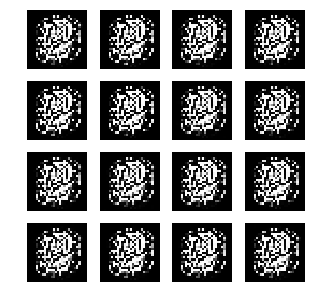

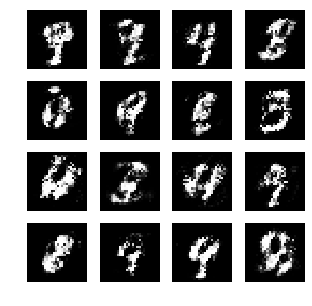

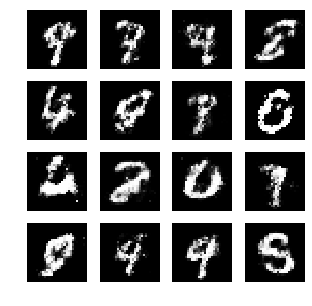

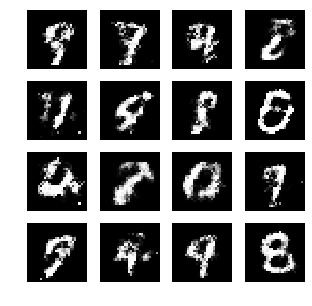

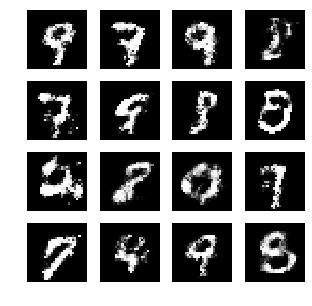

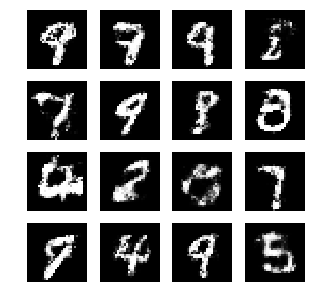

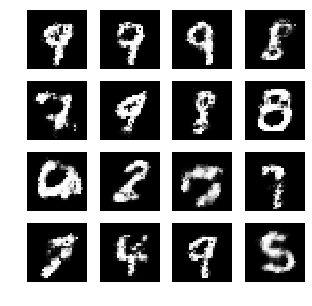

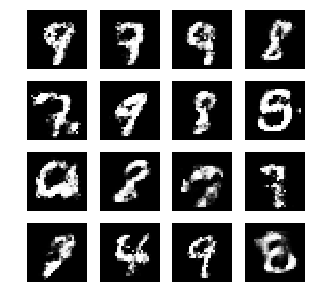

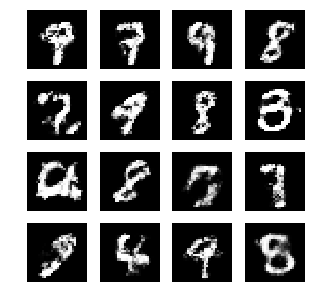

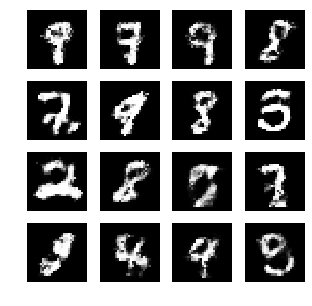

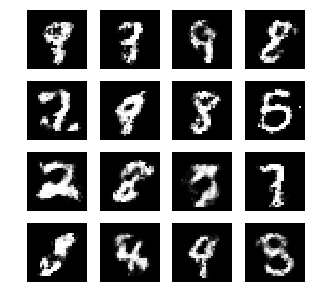

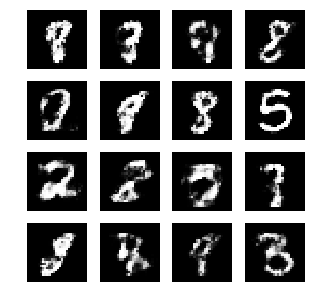

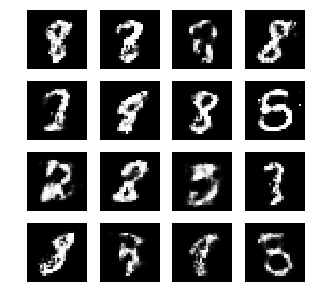

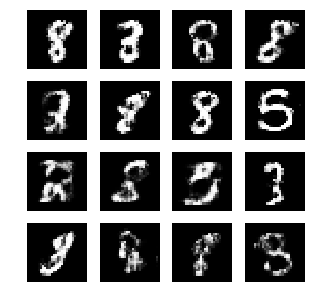

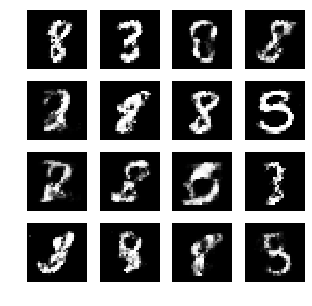

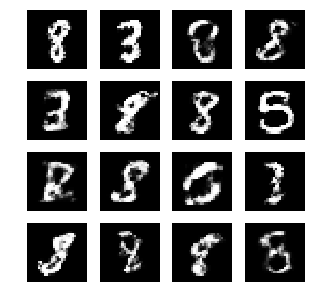

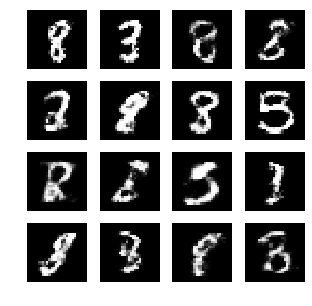

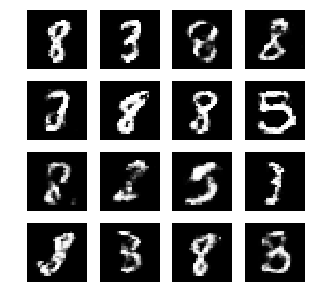

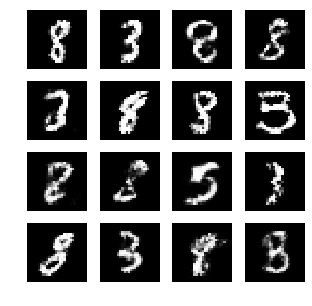

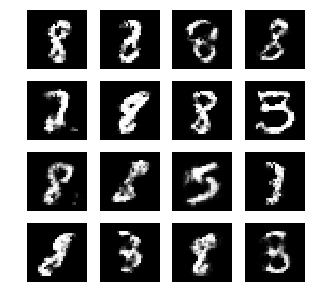

In [13]:
gen_loss_list = []
disc_loss_list = []
training_start_time = time.time()
for epoch in range(epochs):
    start = time.time()
    total_gen_loss = 0
    total_disc_loss = 0
    total_disc_real_acc = 0
    total_disc_gen_acc = 0
    count = 0

    for images,labels in train_ds:
#         print(images.shape)
        batch_s = images.shape[0]
        gen_loss, disc_loss, disc_real_acc, disc_gen_acc = train_step(images, batch_s)

        total_gen_loss += gen_loss
        total_disc_loss += disc_loss
        total_disc_real_acc += disc_real_acc
        total_disc_gen_acc += disc_gen_acc
        count += 1
    gen_loss_list.append(total_gen_loss.numpy()/count)
    disc_loss_list.append(total_disc_loss.numpy()/count)
    print('Time for epoch {} is {} sec - gen_loss = {}, disc_loss = {}, disc_real_acc = {}, disc_gen_acc = {}'.format(epoch + 1, 
                                                                                                   round(time.time() - start, 3), 
                                                                                                   round(total_gen_loss.numpy() / count, 3), 
                                                                                                   round(total_disc_loss.numpy() / count, 3), 
                                                                                                   round(total_disc_real_acc.numpy()/count, 2), 
                                                                                                   round(total_disc_gen_acc.numpy()/count, 2)))
    if epoch % save_interval == 0:
        save_imgs(epoch, gen, vis_noise)
training_time_in_hrs = (time.time() - training_start_time) / (60*60)
print('Total training time: {} hrs'.format(training_time_in_hrs))

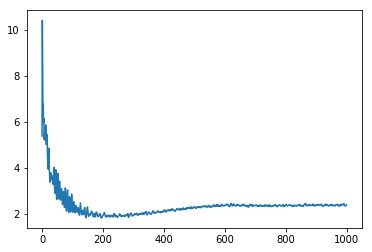

In [14]:
plt.plot(gen_loss_list)
plt.show()

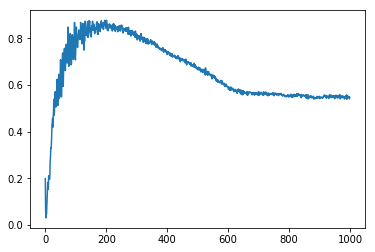

In [15]:
plt.plot(disc_loss_list)
plt.show()